# CHSH Violation Noise Robustness

This notebook investigates the robustness of nonlocal quantum correlation in the CHSH scenario.

1. Scan over noise parameters and optimize the CHSH nonlocality.
2. Compute distance from completely depolarized state and completely dephased state.

1. Plot violation with respect to noise.
2. Plot state distances with respect to noise.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


from context import QNetOptimizer as QNopt

## Trace Distance Metric

We use the trace distance $\text{Tr}|\rho - \sigma|$ to measure the distance between two quantum states $\rho$ and $\sigma$.

In [2]:
def trace_distance(A, B):
    return np.sum([np.abs(eig_val) for eig_val in linalg.svd(A - B, hermitian=True)[1]])/2

##  State Preparations and Measurements

In [3]:
def RY_CNOT(settings, wires):
    qml.RY(settings[0], wires=wires[0])
    qml.RY(settings[1], wires=wires[1])
    qml.CNOT(wires=wires[0:2])

bell_prep_nodes = [
    QNopt.PrepareNode(1, [0, 1], RY_CNOT, 2),
]
arb_prep_nodes = [
    QNopt.PrepareNode(1, [0, 1], qml.templates.subroutines.ArbitraryUnitary, 15)
]

RY_meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], QNopt.local_RY, 1),
    QNopt.MeasureNode(2, 2, [1], QNopt.local_RY, 1),
]

arb_meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], qml.templates.subroutines.ArbitraryUnitary, 3),
    QNopt.MeasureNode(2, 2, [1], qml.templates.subroutines.ArbitraryUnitary, 3)
]

## Main Function for Collecting Data

In [4]:
# We Scan over 11 values in the range [0,1]
params_range = np.append(np.arange(0,1,0.1),[0.999999])
params_range.requires_grad=False

def scan_channel_robustness(prep_nodes, meas_nodes, qubit_channels, scan_range):
    
    opt_violations = np.zeros((11,11))
    noiseless_violations = np.zeros((11,11))
    
    depolarized_distances = np.zeros((11,11))
    noiseless_depolarized_distances = np.zeros((11,11))
    
    classical_distances = np.zeros((11,11))
    noiseless_classical_distances = np.zeros((11,11))
    
    p1_scan_params, p2_scan_params = np.meshgrid(scan_range,scan_range)
      
    ideal_chsh_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes)
    noiseless_chsh_cost = QNopt.chsh_inequality_cost(ideal_chsh_ansatz)
    for i in range(11):
        for j in range(11):
            chan_params = [p1_scan_params[i,j],p2_scan_params[i,j]]
            
            print("Channel Parameters : ", chan_params)

            noise_nodes = [
                QNopt.NoiseNode([0], lambda settings, wires: qubit_channels[0](chan_params[0], wires=wires[0])),
                QNopt.NoiseNode([1], lambda settings, wires: qubit_channels[1](chan_params[1], wires=wires[0]))
            ]

            noisy_chsh_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes, noise_nodes)

            @qml.qnode(noisy_chsh_ansatz.dev)
            def noisy_state(prep_settings):
                noisy_chsh_ansatz.circuit_layer(noisy_chsh_ansatz.prepare_nodes)(prep_settings)
                noisy_chsh_ansatz.circuit_layer(noisy_chsh_ansatz.noise_nodes)(chan_params)

                return qml.state()

            @qml.qnode(noisy_chsh_ansatz.dev)
            def noiseless_state(prep_settings):
                ideal_chsh_ansatz.circuit_layer(ideal_chsh_ansatz.prepare_nodes)(prep_settings)

                return qml.state()

            noisy_chsh_cost = QNopt.chsh_inequality_cost(noisy_chsh_ansatz)
            init_settings = noisy_chsh_ansatz.rand_scenario_settings()

            opt_dict = QNopt.gradient_descent(
                noisy_chsh_cost,
                init_settings,
                num_steps = 55,
                step_size = 0.5,
                sample_width = 5,
                verbose=False
            )    
            
            opt_violations[i,j] = opt_dict["opt_score"]
            noiseless_violations[i,j] = -(noiseless_chsh_cost(opt_dict["opt_settings"]))

            noisy_rho = noisy_state(opt_dict["opt_settings"][0][0][0])
            ideal_rho = noiseless_state(opt_dict["opt_settings"][0][0][0])

            depolarized_distances[i,j] = trace_distance(noisy_rho, np.eye(4)/4)
            noiseless_depolarized_distances[i,j] = trace_distance(ideal_rho, np.eye(4)/4)

            classical_distances[i,j] = trace_distance(noisy_rho, np.diagflat(np.diag(noisy_rho)))
            noiseless_classical_distances[i,j] = trace_distance(ideal_rho, np.diagflat(np.diag(ideal_rho)))
    
    return (
        opt_violations,
        noiseless_violations,
        depolarized_distances,
        noiseless_depolarized_distances,
        classical_distances,
        noiseless_classical_distances,
    )

## Depolarizing Channel

In [5]:
%%time

(
    depo_violations,
    depo_noiseless_violations,
    depo_depolarized_distances,
    depo_noiseless_depolarized_distances,
    depo_classical_distances,
    depo_noiseless_classical_distances,
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.DepolarizingChannel,qml.DepolarizingChannel],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0., requires_grad=False)]
Channe

Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0.9, requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.9, requires_grad=Fal

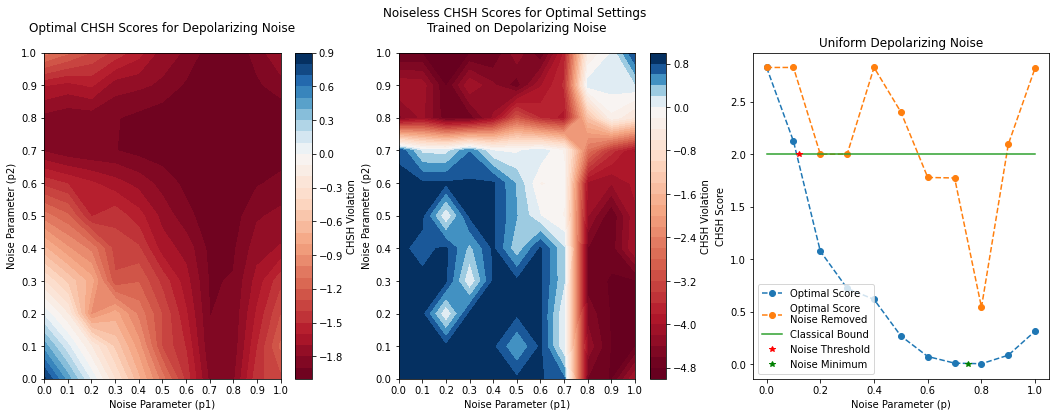

In [6]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=(depo_violations-2).min(), vmax = (depo_violations-2).max(), vcenter=0)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=(depo_noiseless_violations-2).min(),
    vmax = (depo_noiseless_violations-2).max(),
    vcenter=0
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, depo_violations-2, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Depolarizing Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, depo_noiseless_violations-2, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("CHSH Violation")
ax2.set_title("Noiseless CHSH Scores for Optimal Settings \nTrained on Depolarizing Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

depo_uniform_scores = [depo_violations[i,i] for i in range(11)]
depo_noiseless_uniform_scores = [depo_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), depo_uniform_scores, "o--", label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), depo_noiseless_uniform_scores, "o--", label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [2]*11, label="Classical Bound" )
ax3.plot([(1-1/2**(1/4))jn], [2], "r*", label="Noise Threshold")
ax3.plot([3/4],[0], "g*", label="Noise Minimum")
ax3.legend(loc="lower left")
ax3.set_title("Uniform Depolarizing Noise")
ax3.set_ylabel("CHSH Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

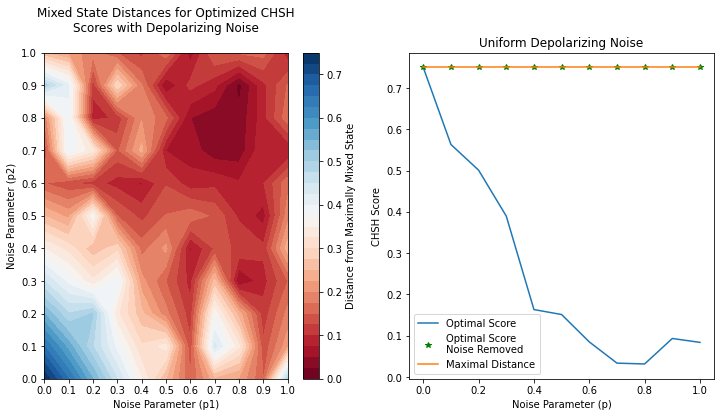

In [7]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, depo_depolarized_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Maximally Mixed State")
ax1.set_title("Mixed State Distances for Optimized CHSH\nScores with Depolarizing Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

depo_uniform_depolarized_distances = [depo_depolarized_distances[i,i] for i in range(11)]
depo_noiseless_uniform_depolarized_distances = [depo_noiseless_depolarized_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), depo_uniform_depolarized_distances, label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), depo_noiseless_uniform_depolarized_distances, "g*", label="Optimal Score\nNoise Removed")
ax2.plot(np.arange(0,1.1,0.1), [0.75]*11, label="Maximal Distance" )
ax2.legend(loc="lower left")
ax2.set_title("Uniform Depolarizing Noise")
ax2.set_ylabel("CHSH Score")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

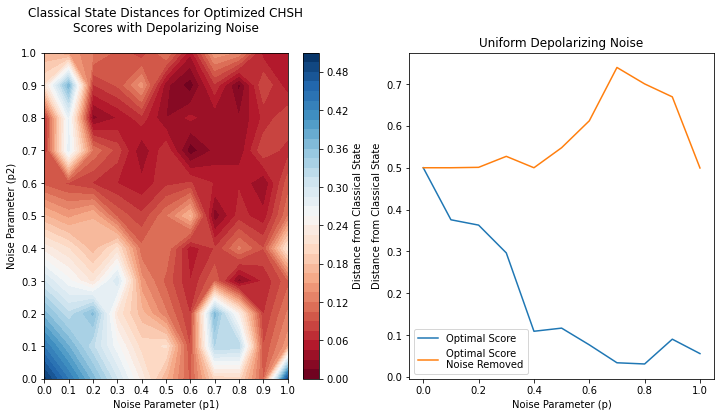

In [8]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, depo_classical_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Classical State")
ax1.set_title("Classical State Distances for Optimized CHSH\nScores with Depolarizing Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

depo_uniform_classical_distances = [depo_classical_distances[i,i] for i in range(11)]
depo_noiseless_uniform_classical_distances = [depo_noiseless_classical_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), depo_uniform_classical_distances, label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), depo_noiseless_uniform_classical_distances, label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Depolarizing Noise")
ax2.set_ylabel("Distance from Classical State")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

## Amplitude Damping

In [9]:
%%time

(
    ampdamp_violations,
    ampdamp_noiseless_violations,
    ampdamp_depolarized_distances,
    ampdamp_noiseless_depolarized_distances,
    ampdamp_classical_distances,
    ampdamp_noiseless_classical_distances,
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.AmplitudeDamping,qml.AmplitudeDamping],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0., requires_grad=False)]
Channe

Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0.9, requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.9, requires_grad=Fal

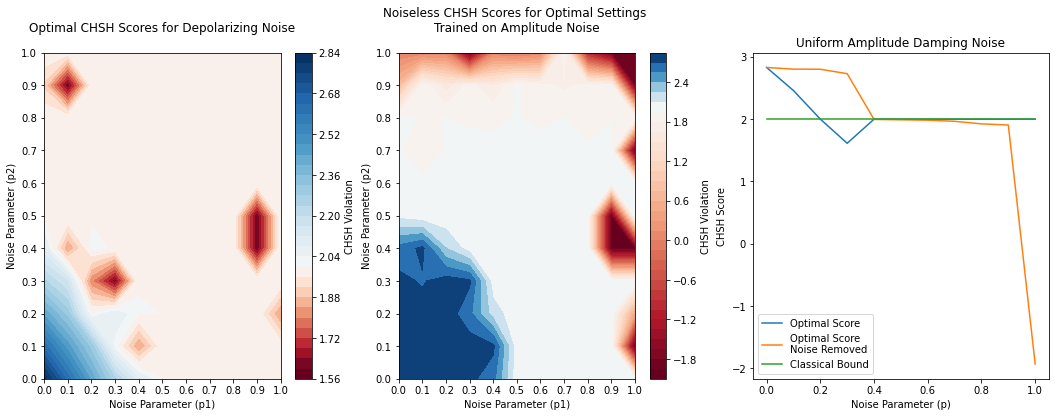

In [10]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=ampdamp_violations.min(), vmax = ampdamp_violations.max(), vcenter=2)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=ampdamp_noiseless_violations.min(),
    vmax = ampdamp_noiseless_violations.max(),
    vcenter=2
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, ampdamp_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Depolarizing Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, ampdamp_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("CHSH Violation")
ax2.set_title("Noiseless CHSH Scores for Optimal Settings \nTrained on Amplitude Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

ampdamp_uniform_scores = [ampdamp_violations[i,i] for i in range(11)]
ampdamp_noiseless_uniform_scores = [ampdamp_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), ampdamp_uniform_scores, label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), ampdamp_noiseless_uniform_scores, label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [2]*11, label="Classical Bound" )
ax3.legend(loc="lower left")
ax3.set_title("Uniform Amplitude Damping Noise")
ax3.set_ylabel("CHSH Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

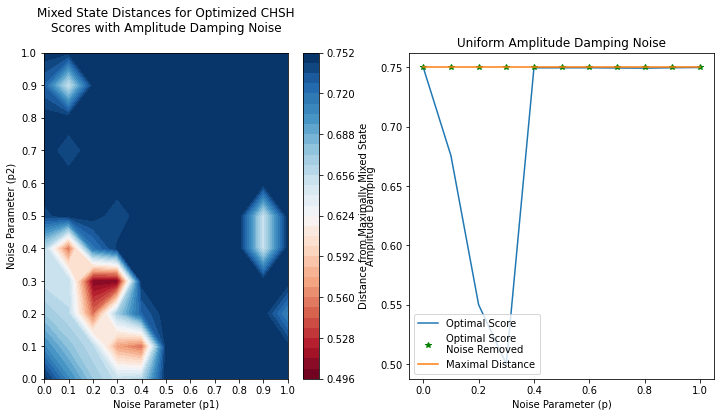

In [11]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, ampdamp_depolarized_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Maximally Mixed State")
ax1.set_title("Mixed State Distances for Optimized CHSH\nScores with Amplitude Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

ampdamp_uniform_depolarized_distances = [ampdamp_depolarized_distances[i,i] for i in range(11)]
ampdamp_noiseless_uniform_depolarized_distances = [ampdamp_noiseless_depolarized_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), ampdamp_uniform_depolarized_distances, label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), ampdamp_noiseless_uniform_depolarized_distances, "g*", label="Optimal Score\nNoise Removed")
ax2.plot(np.arange(0,1.1,0.1), [0.75]*11, label="Maximal Distance" )
ax2.legend(loc="lower left")
ax2.set_title("Uniform Amplitude Damping Noise")
ax2.set_ylabel("Amplitude Damping")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

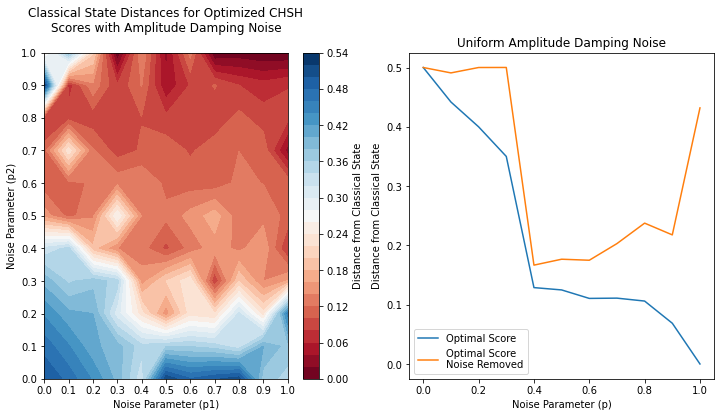

In [12]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, ampdamp_classical_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Classical State")
ax1.set_title("Classical State Distances for Optimized CHSH\nScores with Amplitude Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

ampdamp_uniform_classical_distances = [ampdamp_classical_distances[i,i] for i in range(11)]
ampdamp_noiseless_uniform_classical_distances = [ampdamp_noiseless_classical_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), ampdamp_uniform_classical_distances, label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), ampdamp_noiseless_uniform_classical_distances, label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Amplitude Damping Noise")
ax2.set_ylabel("Distance from Classical State")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

## Phase Damping

In [13]:
%%time

(
    phasedamp_violations,
    phasedamp_noiseless_violations,
    phasedamp_depolarized_distances,
    phasedamp_noiseless_depolarized_distances,
    phasedamp_classical_distances,
    phasedamp_noiseless_classical_distances,
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.PhaseDamping,qml.PhaseDamping],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0., requires_grad=False)]
Channe

Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0.9, requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.9, requires_grad=Fal

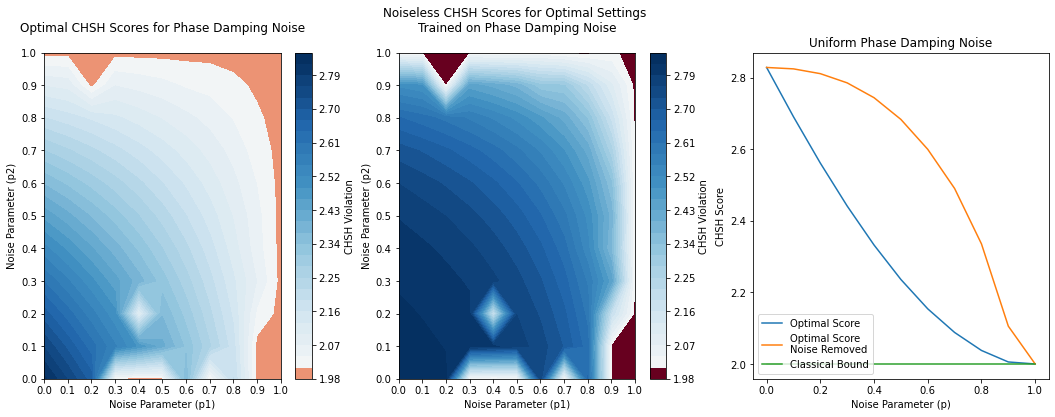

In [14]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=phasedamp_violations.min(), vmax = phasedamp_violations.max(), vcenter=2)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=phasedamp_noiseless_violations.min(),
    vmax = phasedamp_noiseless_violations.max(),
    vcenter=2
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phasedamp_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Phase Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, phasedamp_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("CHSH Violation")
ax2.set_title("Noiseless CHSH Scores for Optimal Settings \nTrained on Phase Damping Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

phasedamp_uniform_scores = [phasedamp_violations[i,i] for i in range(11)]
phasedamp_noiseless_uniform_scores = [phasedamp_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), phasedamp_uniform_scores, label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), phasedamp_noiseless_uniform_scores, label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [2]*11, label="Classical Bound" )
ax3.legend(loc="lower left")
ax3.set_title("Uniform Phase Damping Noise")
ax3.set_ylabel("CHSH Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

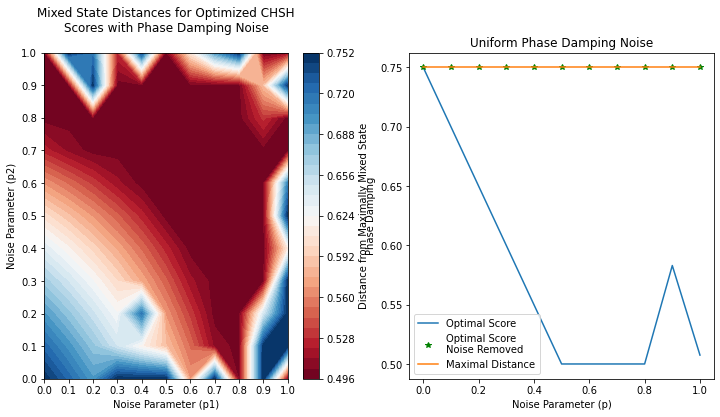

In [15]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phasedamp_depolarized_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Maximally Mixed State")
ax1.set_title("Mixed State Distances for Optimized CHSH\nScores with Phase Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

phasedamp_uniform_depolarized_distances = [phasedamp_depolarized_distances[i,i] for i in range(11)]
phasedamp_noiseless_uniform_depolarized_distances = [phasedamp_noiseless_depolarized_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), phasedamp_uniform_depolarized_distances, label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), phasedamp_noiseless_uniform_depolarized_distances, "g*", label="Optimal Score\nNoise Removed")
ax2.plot(np.arange(0,1.1,0.1), [0.75]*11, label="Maximal Distance" )
ax2.legend(loc="lower left")
ax2.set_title("Uniform Phase Damping Noise")
ax2.set_ylabel("Phase Damping")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

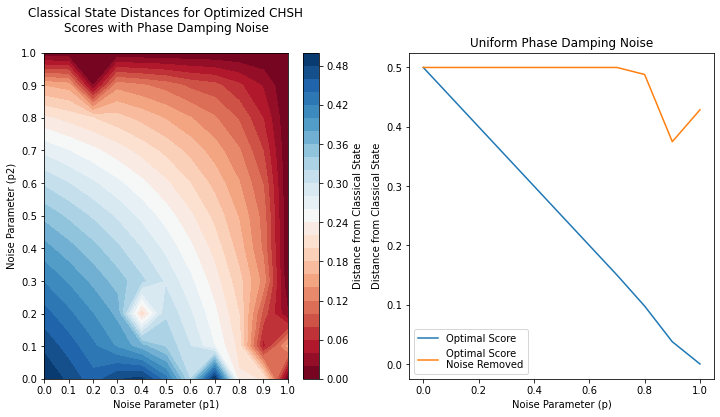

In [16]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phasedamp_classical_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Classical State")
ax1.set_title("Classical State Distances for Optimized CHSH\nScores with Phase Damping Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

phasedamp_uniform_classical_distances = [phasedamp_classical_distances[i,i] for i in range(11)]
phasedamp_noiseless_uniform_classical_distances = [phasedamp_noiseless_classical_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), phasedamp_uniform_classical_distances, label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), phasedamp_noiseless_uniform_classical_distances, label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Phase Damping Noise")
ax2.set_ylabel("Distance from Classical State")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

## Bit Flip

In [17]:
%%time

(
    bitflip_violations,
    bitflip_noiseless_violations,
    bitflip_depolarized_distances,
    bitflip_noiseless_depolarized_distances,
    bitflip_classical_distances,
    bitflip_noiseless_classical_distances,
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.BitFlip, qml.BitFlip],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0., requires_grad=False)]
Channe

Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0.9, requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.9, requires_grad=Fal

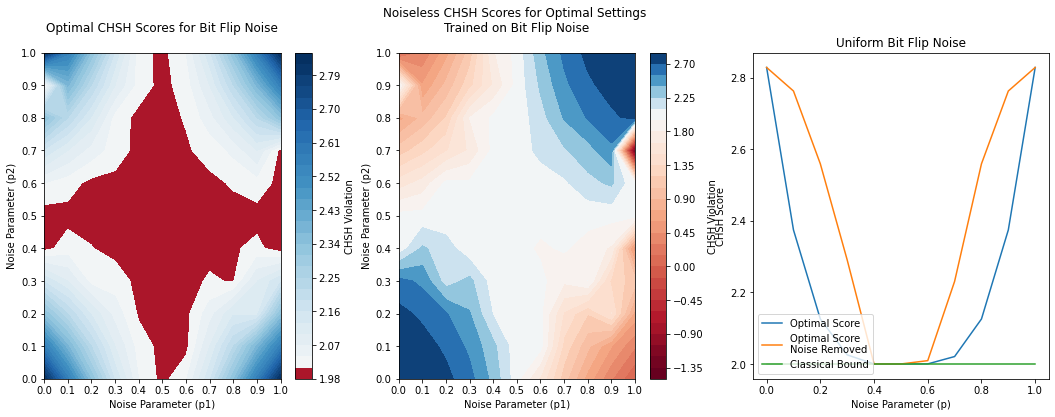

In [18]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=bitflip_violations.min(), vmax = bitflip_violations.max(), vcenter=2)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=bitflip_noiseless_violations.min(),
    vmax = bitflip_noiseless_violations.max(),
    vcenter=2
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, bitflip_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Bit Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, bitflip_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("CHSH Violation")
ax2.set_title("Noiseless CHSH Scores for Optimal Settings \nTrained on Bit Flip Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

bitflip_uniform_scores = [bitflip_violations[i,i] for i in range(11)]
bitflip_noiseless_uniform_scores = [bitflip_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), bitflip_uniform_scores, label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), bitflip_noiseless_uniform_scores, label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [2]*11, label="Classical Bound" )
ax3.legend(loc="lower left")
ax3.set_title("Uniform Bit Flip Noise")
ax3.set_ylabel("CHSH Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

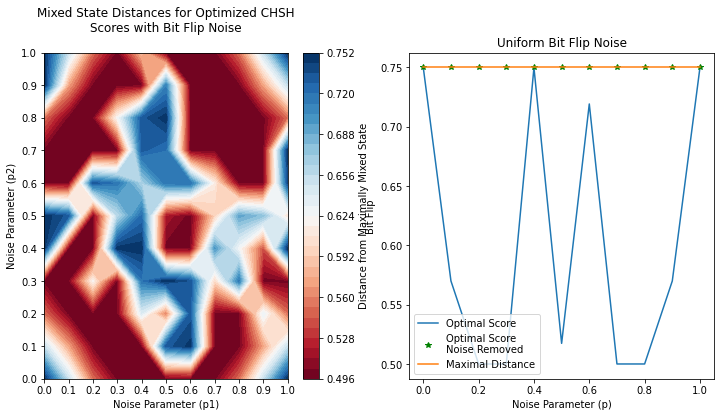

In [19]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, bitflip_depolarized_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Maximally Mixed State")
ax1.set_title("Mixed State Distances for Optimized CHSH\nScores with Bit Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

bitflip_uniform_depolarized_distances = [bitflip_depolarized_distances[i,i] for i in range(11)]
bitflip_noiseless_uniform_depolarized_distances = [bitflip_noiseless_depolarized_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), bitflip_uniform_depolarized_distances, label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), bitflip_noiseless_uniform_depolarized_distances, "g*", label="Optimal Score\nNoise Removed")
ax2.plot(np.arange(0,1.1,0.1), [0.75]*11, label="Maximal Distance" )
ax2.legend(loc="lower left")
ax2.set_title("Uniform Bit Flip Noise")
ax2.set_ylabel("Bit Flip")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

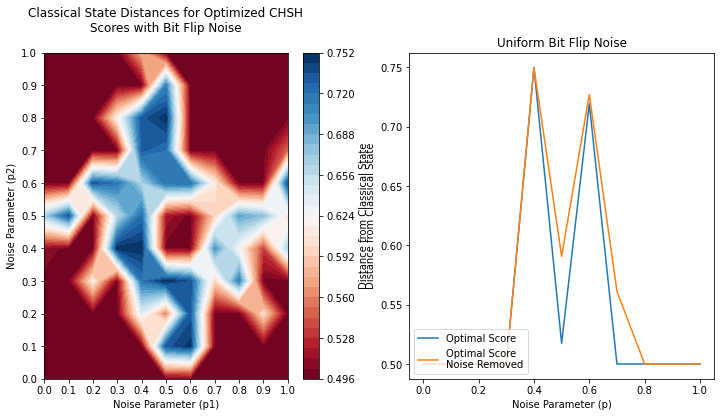

In [20]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, bitflip_classical_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Classical State")
ax1.set_title("Classical State Distances for Optimized CHSH\nScores with Bit Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

bitflip_uniform_classical_distances = [bitflip_classical_distances[i,i] for i in range(11)]
bitflip_noiseless_uniform_classical_distances = [bitflip_noiseless_classical_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), bitflip_uniform_classical_distances, label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), bitflip_noiseless_uniform_classical_distances, label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Bit Flip Noise")
ax2.set_ylabel("Distance from Classical State")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

## Phase Flip

In [21]:
%%time

(
    phaseflip_violations,
    phaseflip_noiseless_violations,
    phaseflip_depolarized_distances,
    phaseflip_noiseless_depolarized_distances,
    phaseflip_classical_distances,
    phaseflip_noiseless_classical_distances
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.PhaseFlip, qml.PhaseFlip],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0., requires_grad=False)]
Channe

Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0.9, requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.9, requires_grad=Fal

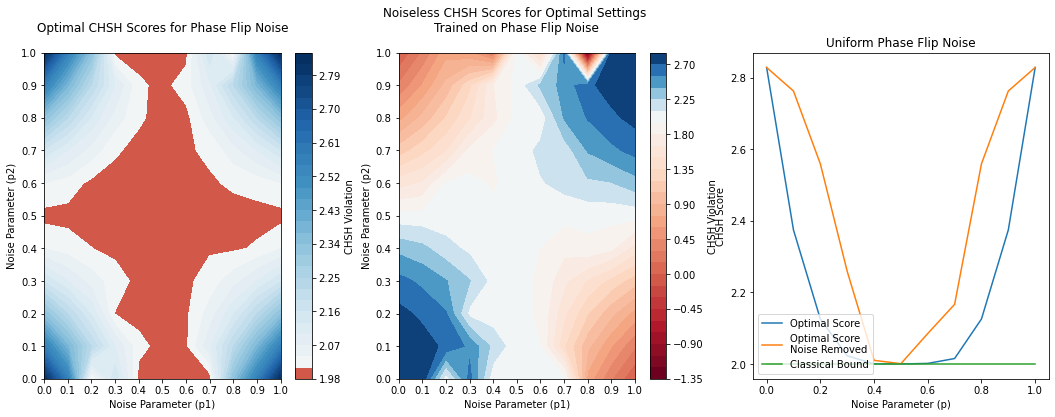

In [22]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=phaseflip_violations.min(), vmax = phaseflip_violations.max(), vcenter=2)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=phaseflip_noiseless_violations.min(),
    vmax = phaseflip_noiseless_violations.max(),
    vcenter=2
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phaseflip_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Phase Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, phaseflip_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("CHSH Violation")
ax2.set_title("Noiseless CHSH Scores for Optimal Settings \nTrained on Phase Flip Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

phaseflip_uniform_scores = [phaseflip_violations[i,i] for i in range(11)]
phaseflip_noiseless_uniform_scores = [phaseflip_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), phaseflip_uniform_scores, label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), phaseflip_noiseless_uniform_scores, label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [2]*11, label="Classical Bound" )
ax3.legend(loc="lower left")
ax3.set_title("Uniform Phase Flip Noise")
ax3.set_ylabel("CHSH Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()

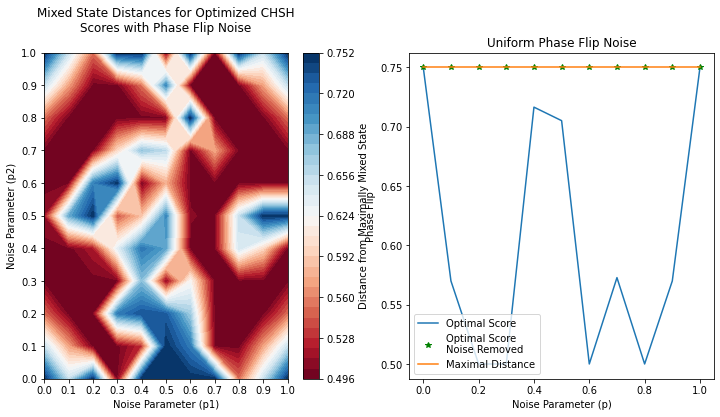

In [23]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phaseflip_depolarized_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Maximally Mixed State")
ax1.set_title("Mixed State Distances for Optimized CHSH\nScores with Phase Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

phaseflip_uniform_depolarized_distances = [phaseflip_depolarized_distances[i,i] for i in range(11)]
phaseflip_noiseless_uniform_depolarized_distances = [phaseflip_noiseless_depolarized_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), phaseflip_uniform_depolarized_distances, label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), phaseflip_noiseless_uniform_depolarized_distances, "g*", label="Optimal Score\nNoise Removed")
ax2.plot(np.arange(0,1.1,0.1), [0.75]*11, label="Maximal Distance" )
ax2.legend(loc="lower left")
ax2.set_title("Uniform Phase Flip Noise")
ax2.set_ylabel("Phase Flip")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

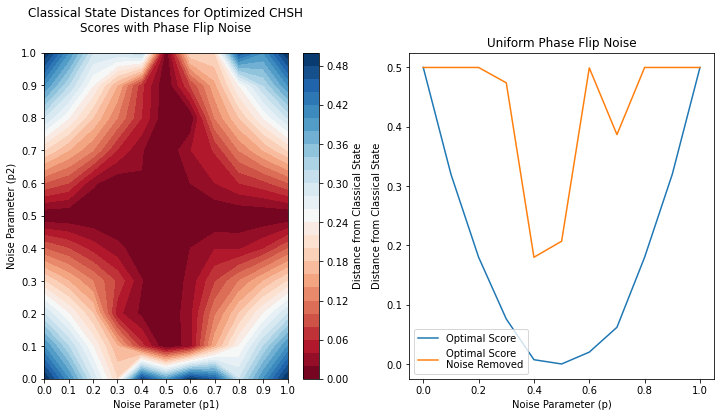

In [24]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phaseflip_classical_distances, 32, cmap="RdBu")
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("Distance from Classical State")
ax1.set_title("Classical State Distances for Optimized CHSH\nScores with Phase Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

phaseflip_uniform_classical_distances = [phaseflip_classical_distances[i,i] for i in range(11)]
phaseflip_noiseless_uniform_classical_distances = [phaseflip_noiseless_classical_distances[i,i] for i in range(11)]

plt2 = plt.plot(np.arange(0,1.1,0.1), phaseflip_uniform_classical_distances, label="Optimal Score")
ax2.plot(np.arange(0,1.1,0.1), phaseflip_noiseless_uniform_classical_distances, label="Optimal Score\nNoise Removed")
ax2.legend(loc="lower left")
ax2.set_title("Uniform Phase Flip Noise")
ax2.set_ylabel("Distance from Classical State")
ax2.set_xlabel("Noise Parameter (p)")

plt.show()

## Amplitude Damping and Phase Damping

In [25]:
%%time

(
    phaseamp_violations,
    phaseamp_noiseless_violations,
    phaseamp_depolarized_distances,
    phaseamp_noiseless_depolarized_distances,
    phaseamp_classical_distances,
    phaseamp_noiseless_classical_distances
) = scan_channel_robustness(
    bell_prep_nodes,
    RY_meas_nodes,
    [qml.PhaseDamping, qml.AmplitudeDamping],
    params_range
)

Channel Parameters :  [tensor(0., requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0., requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0., requires_grad=False)]
Channe

Channel Parameters :  [tensor(0.2, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.3, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.4, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.5, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.6, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.7, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.8, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.9, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0.999999, requires_grad=False), tensor(0.8, requires_grad=False)]
Channel Parameters :  [tensor(0., requires_grad=False), tensor(0.9, requires_grad=False)]
Channel Parameters :  [tensor(0.1, requires_grad=False), tensor(0.9, requires_grad=Fal

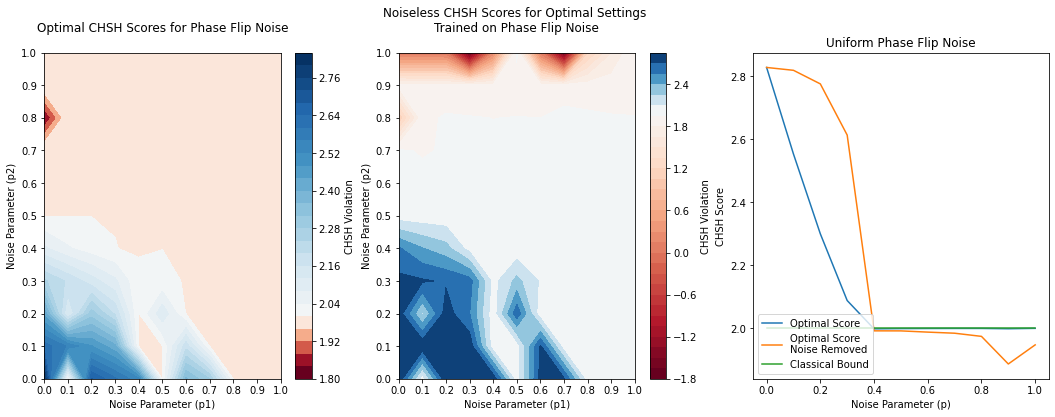

In [26]:
p1_scan_params, p2_scan_params = np.meshgrid(params_range,params_range)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))

norm_noisy = mcolors.TwoSlopeNorm(vmin=phaseamp_violations.min(), vmax = phaseamp_violations.max(), vcenter=2)
norm_noiseless = mcolors.TwoSlopeNorm(
    vmin=phaseamp_noiseless_violations.min(),
    vmax = phaseamp_noiseless_violations.max(),
    vcenter=2
)

plt1 = ax1.contourf(p1_scan_params, p2_scan_params, phaseamp_violations, 32, cmap="RdBu", norm=norm_noisy)
clb1 = plt.colorbar(plt1, ax=ax1)
clb1.set_label("CHSH Violation")
ax1.set_title("Optimal CHSH Scores for Phase Flip Noise\n")
ax1.set_ylabel("Noise Parameter (p2)")
ax1.set_xlabel("Noise Parameter (p1)")
ax1.set_xticks(np.arange(0,1.01,0.1))
ax1.set_yticks(np.arange(0,1.01,0.1))

plt2 = ax2.contourf(p1_scan_params, p2_scan_params, phaseamp_noiseless_violations, 32, cmap="RdBu", norm=norm_noiseless)
clb2 = plt.colorbar(plt2, ax=ax2)
clb2.set_label("CHSH Violation")
ax2.set_title("Noiseless CHSH Scores for Optimal Settings \nTrained on Phase Flip Noise\n")
ax2.set_ylabel("Noise Parameter (p2)")
ax2.set_xlabel("Noise Parameter (p1)")
ax2.set_xticks(np.arange(0,1.01,0.1))
ax2.set_yticks(np.arange(0,1.01,0.1))

phaseamp_uniform_scores = [phaseamp_violations[i,i] for i in range(11)]
phaseamp_noiseless_uniform_scores = [phaseamp_noiseless_violations[i,i] for i in range(11)]

plt3 = plt.plot(np.arange(0,1.1,0.1), phaseamp_uniform_scores, label="Optimal Score")
ax3.plot(np.arange(0,1.1,0.1), phaseamp_noiseless_uniform_scores, label="Optimal Score\nNoise Removed")
ax3.plot(np.arange(0,1.1,0.1), [2]*11, label="Classical Bound" )
ax3.legend(loc="lower left")
ax3.set_title("Uniform Phase Flip Noise")
ax3.set_ylabel("CHSH Score")
ax3.set_xlabel("Noise Parameter (p)")

plt.show()